In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from scipy import optimize
from scipy import linalg
import scipy.optimize as so

In [2]:
def growth_rate(s, b, gamma): #This function returns the growth rate
    B = (b.T * s).T 
    M = B - np.eye(len(s))*gamma #The largest eigenvalue of M is the growth rate of the epidemic
    EV = linalg.eigvals(M)
    gr = np.amax(EV) #Growth rate
    return gr 

In [3]:
def FS(x, b, n, g): ## This function gives the final size using the above defined parameters
    return [x[k] - n[k]*(1-np.exp(-np.sum(b[k]*x/g))) for k in range(len(n))]

In [4]:
def LCFS(a, x): #Expression for linear combination of final sizes 'x'.
    return np.sum(a*x) #a and x are arrays with three elements

In [5]:
def c_typeII_eqn(c, b, r, n):
    #return np.array([np.sum(b[0]*(1-c[0])*(1-c)*r) + np.log(1-r[0]/n[0]), np.sum(b[1]*(1-c[1])*(1-c)*r) + np.log(1-r[1]/n[1]), np.sum(b[2]*(1-c[2])*(1-c)*r) + np.log(1-r[2]/n[2])])
    return np.array([np.sum(b[k]*(1-c[k])*(1-c)*r) + np.log(1-r[k]/n[k]) for k in range(len(n))])
    
def c_typeII(r, b, n):
    sol = so.root(c_typeII_eqn, np.random.uniform(-1, 1, len(n)), args = (b, r, n)) #Using a numerical solver to find the c values
    return (sol)
    

Contour plot - parameter space

In [6]:
n = np.array([0.4, 0.6]) #Define the sizes of sub-populations
no_g = len(n)
gamma = 1 #Recovery rate
#A = np.array([1, 1, 1]) #Weights of the objective function that is minimized. [1, 1, 1] means the final size of the epidemic is minimized
A = np.ones(no_g)
#Number of random trials
# b1_list, b2_list, FS_int_list, FS_ord_list = [], [], [], []
# c1_list, c2_list = [], []
# b1_rej, b2_rej, c_rej = [], [], []

#rng = np.random.default_rng(2022)




In [21]:
def compute_final_sizes(b, gamma, n):    
    #b = np.array([[b1**2, b1*b2], [b2*b1, b2**2]])    
    b_c = np.array([b[k]*(1-c[k])*(1-c) for k in range(len(n))])

    count = 0
    FS_ord = 2
    count_max = 20
    fs_flag = False
    while fs_flag == False or FS_ord > 1:
        root_ord = so.root(FS, np.random.uniform(0.5, 1)*n, args = (b, n, gamma)) ## Using a numerical solver to find the final size
        fs_flag = root_ord.success
        FS_ord = np.sum(root_ord.x) ## The final sizes without intervention
        count = count + 1
        if count == count_max:
            break

    root_int = so.root(FS, 0.9*n, args = (b_c, n, gamma))
    FS_int = np.sum(root_int.x)

    return [FS_ord, FS_int]

In [ ]:
def compute_cost_function(A, b, gamma, n):    
    #b = np.array([[b1**2, b1*b2], [b2*b1, b2**2]])    
    b_c = np.array([b[k]*(1-c[k])*(1-c) for k in range(len(n))])

    count = 0
    CF_ord = 2
    count_max = 20
    fs_flag = False
    while fs_flag == False or FS_ord > 1:
        root_ord = so.root(FS, np.random.uniform(0.5, 1)*n, args = (b, n, gamma)) ## Using a numerical solver to find the final size
        fs_flag = root_ord.success
        CF_ord = np.sum(A*root_ord.x) ## The final sizes without intervention
        count = count + 1
        if count == count_max:
            break

    root_int = so.root(FS, 0.9*n, args = (b_c, n, gamma))
    CF_int = np.sum(A*root_int.x)

    return [CF_ord, CF_int]

In [7]:
no_matrices = 3000
max_R = 3.5
min_R = 0.1
matrix_list = []

gr, CF_int, CF_ord, c1, c2 = [], [], [], [], []
residue = []
trials = 10

for j in range(no_matrices):
    b = min_R + np.random.rand(2, 2)*(max_R - min_R)
    tmp = growth_rate(n, b, gamma)
    gr.append(tmp)
    if tmp>=1e-3:
        constraint_growth_rate = optimize.NonlinearConstraint(lambda x: growth_rate(n-x, b, gamma), lb=0, ub=0) #since x is final size, we pass the s array = n-x to the growth rate function
        
        min_cost_list = []
        fs_list = []
        #mcx = np.ones(no_g)
        for j in range(trials):
            optimize_ic = np.random.rand(no_g)*n        
            min_cost_tmp = optimize.minimize(LCFS, x0 = optimize_ic, args = (A), constraints = (constraint_growth_rate), bounds = [(0, n[k]) for k in range(len(n))])
            if j == 0:
                #min_cost = min_cost_tmp.copy()
                mcx = min_cost_tmp.copy()['x']
            elif (A*min_cost_tmp['x']).sum()<(A*mcx).sum():
                #min_size = min_cost_tmp.copy()
                mcx = min_cost_tmp.copy()['x']

        
        
        min_size_approx = min_size['x'].copy()
        if np.abs(min_size['x'][0] - n[0])<1e-3: 
            min_size_approx[0] = 0.99*min_size_approx[0]
        if np.abs(min_size['x'][1] - n[1])<1e-3:
            min_size_approx[1] = 0.99*min_size_approx[1]

        
        sol = so.root(c_typeII_eqn, np.random.uniform(-1, 1, no_g), args = (b, min_size_approx, n))
        for j in range(trials):
            sol_tmp = so.root(c_typeII_eqn, np.random.uniform(-1, 1, no_g), args = (b, min_size_approx, n))
            if np.abs(sol_tmp['fun']).sum()<np.abs(sol['fun']).sum():
                sol = sol_tmp.copy()
                #sol_list.append(sol)
                #dist_list.append(((sol.fun)**2).sum())

        #c, c_flag, c_fun = compute_c(x, y, gamma, n)
        c = sol['x']
        c_flag = sol['success']
        fss = compute_final_sizes(b, gamma, n)
        
        
        if c_flag == True:
            c1.append(c[0])
            c2.append(c[1])
            FS_ord.append(fss[0])
            FS_int.append(fss[1])
            #residue.append(c_fun)
        else:
            c1.append(float('NaN'))
            c2.append(float('NaN'))
            FS_ord.append(float('NaN'))
            FS_int.append(float('NaN'))
        
    else:
        c1.append(float('NaN'))
        c2.append(float('NaN'))
        FS_ord.append(float('NaN'))
        FS_int.append(float('NaN'))

34

In [22]:
#b1_list = np.arange(0.1, 3.5, 0.1)
#b2_list = np.arange(0.1, 3.5, 0.1)
db = 0.1
b1_list = np.arange(0.1, 3.5, db)
b2_list = np.arange(0.1, 3.5, db)
b1, b2, gr, FS_int, FS_ord, c1, c2 = [], [], [], [], [], [], []
residue = []
trials = 10
for x in b1_list:
    for y in b2_list:
        b1.append(x)
        b2.append(y)
        tmp = growth_rate(n, np.array([[x**2, x*y], [y*x, y**2]]), gamma)
        gr.append(tmp)
        if tmp>=1e-3:
            b = np.array([[x**2, x*y], [y*x, y**2]])  
            constraint_growth_rate = optimize.NonlinearConstraint(lambda x: growth_rate(n-x, b, gamma), lb=0, ub=0) #since x is final size, we pass the s array = n-x to the growth rate function
            
            min_size_list = []
            fs_list = []
            msx = np.ones(no_g)
            for j in range(trials):
                optimize_ic = np.random.rand(2)*n        
                min_size_tmp = optimize.minimize(LCFS, x0 = optimize_ic, args = (A), constraints = (constraint_growth_rate), bounds = [(0, n[k]) for k in range(len(n))])
                if j == 0:
                    min_size = min_size_tmp.copy()
                    msx = min_size['x']
                elif min_size_tmp['x'].sum()<msx.sum():
                    min_size = min_size_tmp.copy()
                    msx = min_size['x']

            
            
            min_size_approx = min_size['x'].copy()
            if np.abs(min_size['x'][0] - n[0])<1e-3: 
                min_size_approx[0] = 0.99*min_size_approx[0]
            if np.abs(min_size['x'][1] - n[1])<1e-3:
                min_size_approx[1] = 0.99*min_size_approx[1]

            
            sol = so.root(c_typeII_eqn, np.random.uniform(-1, 1, no_g), args = (b, min_size_approx, n))
            for j in range(trials):
                sol_tmp = so.root(c_typeII_eqn, np.random.uniform(-1, 1, no_g), args = (b, min_size_approx, n))
                if np.abs(sol_tmp['fun']).sum()<np.abs(sol['fun']).sum():
                    sol = sol_tmp.copy()
                    #sol_list.append(sol)
                    #dist_list.append(((sol.fun)**2).sum())

            #c, c_flag, c_fun = compute_c(x, y, gamma, n)
            c = sol['x']
            c_flag = sol['success']
            fss = compute_final_sizes(x, y, gamma, n)
            
            
            if c_flag == True:
                c1.append(c[0])
                c2.append(c[1])
                FS_ord.append(fss[0])
                FS_int.append(fss[1])
                #residue.append(c_fun)
            else:
                c1.append(float('NaN'))
                c2.append(float('NaN'))
                FS_ord.append(float('NaN'))
                FS_int.append(float('NaN'))
            
        else:
            c1.append(float('NaN'))
            c2.append(float('NaN'))
            FS_ord.append(float('NaN'))
            FS_int.append(float('NaN'))

b1_matrix = np.real(np.reshape(b1, (len(b1_list), len(b2_list))))
b2_matrix = np.real(np.reshape(b2, (len(b1_list), len(b2_list))))
gr_matrix = np.real(np.reshape(gr, (len(b1_list), len(b2_list))))
FS_ord_matrix = np.real(np.reshape(FS_ord, (len(b1_list), len(b2_list))))
FS_int_matrix = np.real(np.reshape(FS_int, (len(b1_list), len(b2_list))))
c1_matrix = np.real(np.reshape(c1, (len(b1_list), len(b2_list))))
c2_matrix = np.real(np.reshape(c2, (len(b1_list), len(b2_list))))

c:\Users\pkollepara\Miniconda3\envs\LTU\lib\site-packages\scipy\optimize\_numdiff.py:579: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
c:\Users\pkollepara\Miniconda3\envs\LTU\lib\site-packages\scipy\optimize\slsqp.py:427: ComplexWarning: Casting complex values to real discards the imaginary part
  slsqp(m, meq, x, xl, xu, fx, c, g, a, acc, majiter, mode, w, jw,


from shifted_color_map import shiftedColorMap

fig, ax = plt.subplots(1, 2, figsize = (2*8, 6)) 
plt.suptitle(r'$n_1 = %.2f, \ n_2 = %.2f, \ G_{kl} = n_k b_k b_l$'%(n[0], n[1]))
#custom_cmap_1.set_bad(color='grey')
#custom_cmap_2.set_bad(color='grey')
im1 = ax[0].imshow(FS_ord_matrix.T, cmap = 'viridis', extent = (b1[0]-db/2, b1[-1]+db/2, b2[0]-db/2, b2[-1]+db/2), origin = 'lower', interpolation = 'none', aspect = 'equal')
fig.colorbar(im1, ax=ax[0], location = 'bottom')
#co1 = ax[0].contour(b1_matrix, b2_matrix, FS_ord_matrix, colors = 'k', linewidths = 0.5)
#ax[0].clabel(co1, inline=True, fontsize='small')

im2 = ax[1].imshow(FS_int_matrix.T, cmap = 'viridis', extent = (b1[0], b1[-1], b2[0], b2[-1]), origin = 'lower', interpolation = 'none', aspect = 'equal')
fig.colorbar(im2, ax=ax[1], location = 'bottom')
#co2 = ax[1].contour(b1_matrix, b2_matrix, FS_ord_matrix, colors = 'k', linewidths = 0.5)
#ax[1].clabel(co2, inline=True, fontsize='small')

ax[0].set_xlabel(r'$b_1$')
ax[0].set_ylabel(r'$b_2$')
ax[0].set_title(r'FS_ord')
ax[1].set_xlabel(r'$b_1$')
ax[1].set_ylabel(r'$b_2$')
ax[1].set_title(r'FS_int')
#im2 = ax[1].imshow(epidemic_size_matrix.T, cmap = 'copper', extent = (s0[0], s0[-1], s1[0], s1[-1]), origin = 'lower', interpolation = 'none', aspect 
#plt.savefig('matrix_space_c_A.pdf')

custom_cmap_1 = shiftedColorMap(cm.get_cmap('PiYG').copy(), np.nanmin(c1), midpoint = 0, stop = 1, name = 'custom_1')
custom_cmap_2 = shiftedColorMap(cm.get_cmap('PiYG').copy(), np.nanmin(c2), midpoint = 0, stop = 1, name = 'custom_2')

In [12]:
#%matplotlib widget

fig, ax = plt.subplots(1, 2, figsize = (2*8, 6)) 
plt.suptitle(r'$n_1 = %.2f, \ n_2 = %.2f, \ G_{kl} = n_k b_k b_l$'%(n[0], n[1]))
custom_cmap_1.set_bad(color='grey')
custom_cmap_2.set_bad(color='grey')
ax[0].scatter(b1, b2, marker = 's', edgecolor = 'k', facecolor = 'none', lw =0.2)
im1 = ax[0].imshow(c1_matrix.T, cmap = custom_cmap_1, extent = (b1[0]-db/2, b1[-1]+db/2, b2[0]-db/2, b2[-1]+db/2), origin = 'lower', interpolation = 'none', aspect = 'equal')
fig.colorbar(im1, ax=ax[0], location = 'bottom')
co1 = ax[0].contour(b1_matrix, b2_matrix, FS_ord_matrix, colors = 'k', linewidths = 0.5)
ax[0].clabel(co1, inline=True, fontsize='small')

ax[1].scatter(b1, b2, marker = 's', edgecolor = 'k', facecolor = 'none', lw =0.2)
im2 = ax[1].imshow(c2_matrix.T, cmap = custom_cmap_2, extent = (b1[0]-db/2, b1[-1]+db/2, b2[0]-db/2, b2[-1]+db/2), origin = 'lower', interpolation = 'none', aspect = 'equal')
fig.colorbar(im2, ax=ax[1], location = 'bottom')
co2 = ax[1].contour(b1_matrix, b2_matrix, FS_ord_matrix, colors = 'k', linewidths = 0.5)
ax[1].clabel(co2, inline=True, fontsize='small')

ax[0].set_xlabel(r'$b_1$')
ax[0].set_ylabel(r'$b_2$')
ax[0].set_title(r'Colorplot of $c_1$')
ax[1].set_xlabel(r'$b_1$')
ax[1].set_ylabel(r'$b_2$')
ax[1].set_title(r'Colorplot of $c_2$')
fig.tight_layout()

#im2 = ax[1].imshow(epidemic_size_matrix.T, cmap = 'copper', extent = (s0[0], s0[-1], s1[0], s1[-1]), origin = 'lower', interpolation = 'none', aspect 
plt.savefig('matrix_space_c_A.pdf')

2.6, 1.85

Plot whether transmission increases or not

In [23]:
b1_increase = np.array(b1)[np.bitwise_or((np.array(c1)<0), np.array(c2)<0)]
b2_increase = np.array(b2)[np.bitwise_or((np.array(c1)<0), np.array(c2)<0)]



In [18]:
b2_increase.shape

(366,)

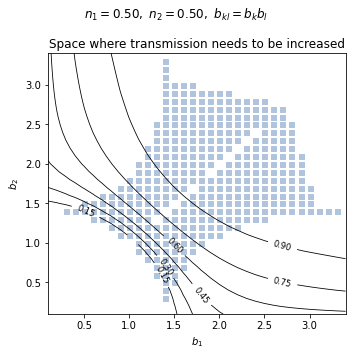

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5)) 
plt.suptitle(r'$n_1 = %.2f, \ n_2 = %.2f, \ b_{kl} = b_k b_l$'%(n[0], n[1]))

im = ax.scatter(b1_increase, b2_increase, s = 25, marker = 's', c = 'lightsteelblue')

co1 = ax.contour(b1_matrix, b2_matrix, FS_ord_matrix, colors = 'k', linewidths = 0.8)
ax.clabel(co1, inline=True, fontsize='small')

ax.set_xlabel(r'$b_1$')
ax.set_ylabel(r'$b_2$')
ax.set_title(r'Space where transmission needs to be increased')
fig.tight_layout()

#plt.savefig('matrix_space_increase_B.pdf')

LaTeX Figure

In [24]:
b1_gray = np.array(b1)[(np.array(gr)<1e-3)]
b2_gray = np.array(b2)[(np.array(gr)<1e-3)]


In [18]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

import matplotlib.pyplot as plt

FontSize = 8
plt.rcParams['axes.linewidth'] = 0.4

plt.rc('font', size=FontSize)          # controls default text sizes
plt.rc('axes', titlesize=FontSize)     # fontsize of the axes title
plt.rc('axes', labelsize=FontSize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FontSize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FontSize)    # fontsize of the tick labels
plt.rc('legend', fontsize=FontSize)    # legend fontsize

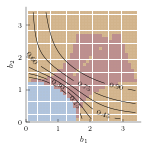

In [25]:
fig, ax = plt.subplots(1, 1, figsize = (5*3.5/8, 5*3.5/8))

#plt.suptitle(r'$n_1 = %.2f, \ n_2 = %.2f, \ b_{kl} = b_k b_l$'%(n[0], n[1]))

ax.scatter(b1, b2, s = 5, marker = 's', facecolor = 'tan')
ax.scatter(b1_gray, b2_gray, s = 5.2, marker = 's', facecolor = 'lightsteelblue')
im = ax.scatter(b1_increase, b2_increase, s = 5.2, marker = 's', facecolor = 'rosybrown')


ax.set_xlabel(r'$b_1$')
ax.set_ylabel(r'$b_2$')
#ax.set_title(r'Space where transmission needs to be increased')
fig.tight_layout()

ax.set_facecolor('none')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params('both', which = 'both', direction = 'in', labelsize = FontSize-1, width = 0.4)
ax.set_xlim(0, )
ax.set_ylim(0, )
plt.locator_params('x', nbins = 4)
plt.locator_params('y', nbins = 4)

ax.set_aspect('equal', 'box')
co1 = ax.contour(b1_matrix, b2_matrix, FS_ord_matrix, colors = 'k', linewidths = 0.5)
ax.clabel(co1, inline=True, fontsize=FontSize-1)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.savefig('matrix_space_increase_n1_%.2f_n2_%.2f.pdf'%(n[0], n[1]))

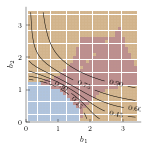

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (5*3.5/8, 5*3.5/8))

#plt.suptitle(r'$n_1 = %.2f, \ n_2 = %.2f, \ b_{kl} = b_k b_l$'%(n[0], n[1]))

ax.scatter(b1, b2, c = 'none')
ax.scatter(b1, b2, s = 5.5, marker = 's', facecolor = 'tan')

ax.scatter(b1_gray, b2_gray, s = 5.5, marker = 's', facecolor = 'lightsteelblue')
im = ax.scatter(b1_increase, b2_increase, s = 5.5, marker = 's', facecolor = 'rosybrown')


ax.set_xlabel(r'$b_1$')
ax.set_ylabel(r'$b_2$')
#ax.set_title(r'Space where transmission needs to be increased')
fig.tight_layout()

ax.set_facecolor('none')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params('both', which = 'both', direction = 'in', labelsize = FontSize-1, width = 0.4)
ax.set_xlim(0, )
ax.set_ylim(0, )
plt.locator_params('x', nbins = 4)
plt.locator_params('y', nbins = 4)

ax.set_aspect('equal', 'box')
co1 = ax.contour(b1_matrix, b2_matrix, FS_ord_matrix, colors = 'k', linewidths = 0.5)
ax.clabel(co1, inline=True, fontsize=FontSize-1)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.savefig('matrix_space_increase_B_2_c.pdf')

In [18]:
b2_list

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4])